# Kinematical diffraction simulation in py4DSTEM

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)

### pymatgen

We use the python package pymatgen for various symmetry calculations of crystals in py4DSTEM. The ACOM module of py4DSTEM can be used without pymatgen, but with substantially reduced functionality. We therefore recommend installing pymatgen if you wish to perform ACOM calculations.

In [1]:
import py4DSTEM

# Defining crystal structures 

In [2]:
# Define fcc gold structure using manual input of the crystal structure
pos = [
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
]
atom_num = 79
a = 4.08
cell = a

crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

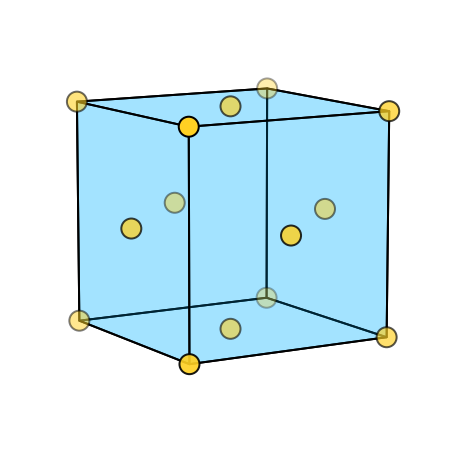

In [3]:
# Plot the structure
crystal.plot_structure(zone_axis_lattice=[5,3,1])

### Other ways to define the crystal structure

In [4]:
# # # Importing pymatgen - you need to install pymatgen and mp-api if you want to use pymatgen structures or their cif importer.
# from pymatgen.core.structure import Structure, Lattice

In [5]:
# # Define gold using pymatgen
# a = 4.08
# fcc_Au = Structure(
#     Lattice.cubic(a), 
#     ["Au", "Au", "Au", "Au"], 
#     [
#     [0.0, 0.0, 0.0],
#     [0.0, 0.5, 0.5],
#     [0.5, 0.0, 0.5],
#     [0.5, 0.5, 0.0],
# ])
# crystal = py4DSTEM.process.diffraction.Crystal.from_pymatgen_structure(fcc_Au)

In [6]:
# # # Plot the structure
# crystal.plot_structure(zone_axis_lattice=[5,3,1])

In [7]:
# py4DSTEM.process.diffraction.Crystal.from_CIF(file_cif)

In [8]:
# # Import the gold structure directly from The Material Project
# crystal = py4DSTEM.process.diffraction.Crystal.from_pymatgen_structure(
#     "mp-752738",
#     MP_key = "", 
# )

In [9]:
# # # Plot the structure
# crystal.plot_structure(zone_axis_lattice=[5,3,1])

# Structure factors

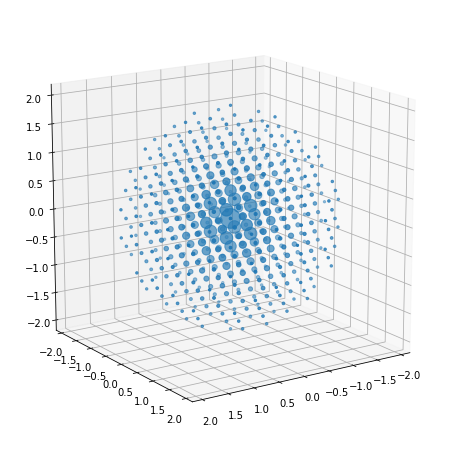

In [10]:
# Calculate and plot the structure factors

k_max = 2.0   # This is the maximum scattering vector included in the following calculations
# k_max = 6.0

crystal.calculate_structure_factors(k_max)

crystal.plot_structure_factors(
    zone_axis_lattice=[3,2,1])

# Generate and plot diffraction patterns

In [11]:
# specify the accelerating voltage
crystal.setup_diffraction(300e3)

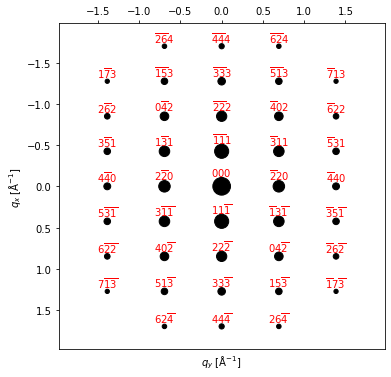

In [12]:
zone_axis_test = [1,1,2]  # Zone axis
# x_proj_test = [1,0,0]  # in-plane projection vector

bragg_peaks = crystal.generate_diffraction_pattern(
    zone_axis_lattice = zone_axis_test,
    # proj_x_lattice = x_proj_test,
    sigma_excitation_error=0.02
)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks,
    # add_labels=False,
)

# Orientation matching

In [13]:
# Create an orientation plan
crystal.orientation_plan()

# # Create an orientation plan with an automatic range of zone axes - this requires pymatgen to be installed!
# crystal.orientation_plan(
#     angle_step_zone_axis = 2.0,
#     angle_step_in_plane = 2.0,
#     accel_voltage = 300e3,
#     corr_kernel_size=0.08,
#     zone_axis_range='auto',
#     # zone_axis_range=np.array([
#     #     [0,0,1],
#     #     [0,1,0],
#     #     [1,0,0],
#     # ]),
# )

Orientation plan: 100%|██████████████████████████████████████████████████████| 406/406 [00:00<00:00, 690.52 zone axes/s]


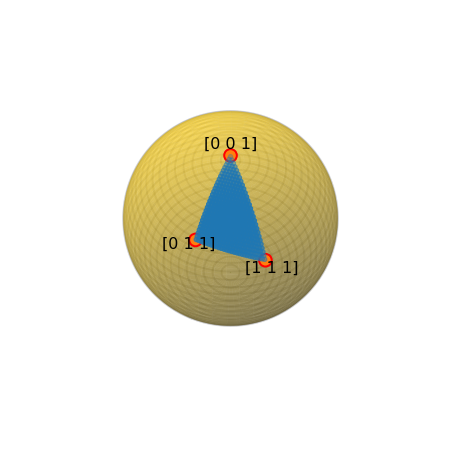

In [14]:
# Plot the zone axes included in the orientation plan
crystal.plot_orientation_zones()

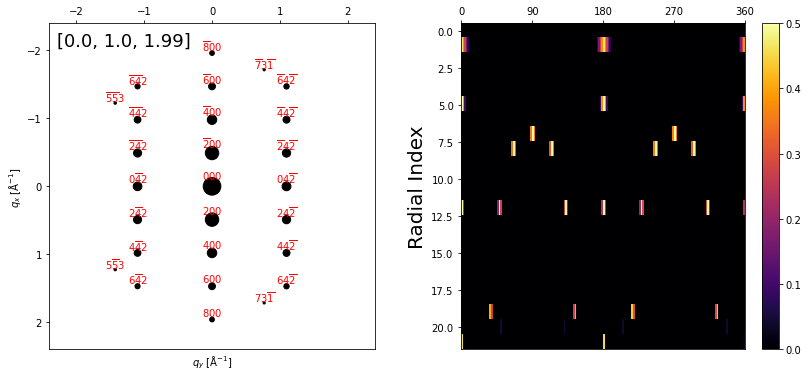

In [15]:
# Plot some of the orientation plans
crystal.plot_orientation_plan(zone_axis_lattice=[0,1,2]);

Input lattice zone axis      = ([0.267 0.535 0.802])
Best fit zone axis (lattice) = ([0.258 0.541 0.801]), with corr value = 2.132


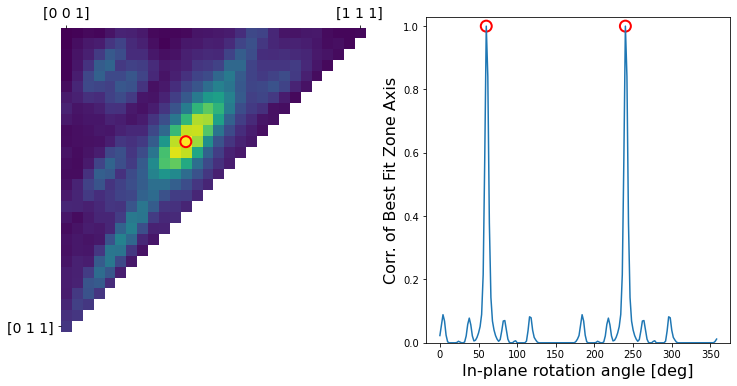

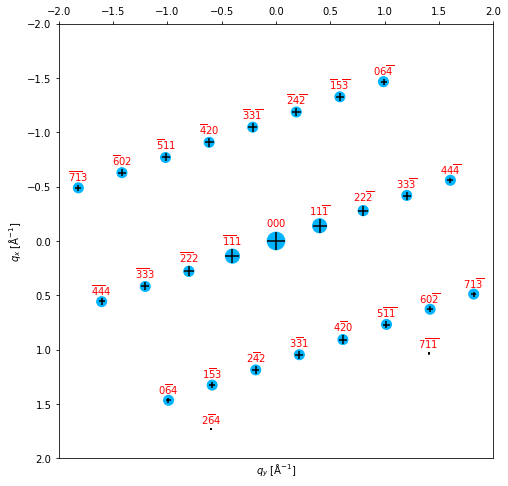

In [16]:
# Testing some matches - this cell shows the orientation correlogram, and the best match for both zone axis and in-plane rotation.
# The input diffraction pattern is shown as blue circles, and the best fit as black crosses.

zone_axis_test = [1,2,3]
# zone_axis_test = [0.25,0.983,0.1345]
# zone_axis_test = [-1,-2,-3]
# zone_axis_test = [0.2,0.4,0.7]

proj_x_test = [-0.24,0.56,0]

bragg_peaks = crystal.generate_diffraction_pattern(
    zone_axis_lattice = zone_axis_test,
    proj_x_lattice = proj_x_test,
    sigma_excitation_error=0.02)

# Print out zone axes after normalization
zone_axis_lattice = crystal.cartesian_to_lattice(zone_axis_test)
print('Input lattice zone axis      = ([' +
      f'{zone_axis_lattice[0]:.{3}f}' + ' ' +
      f'{zone_axis_lattice[1]:.{3}f}' + ' ' +
      f'{zone_axis_lattice[2]:.{3}f}' + '])'
)

# Perform matching, and plot correlation images
orientation, fig, ax = crystal.match_single_pattern(
    bragg_peaks,
    figsize=[12,6],
    plot_corr=True,
    verbose=True,
    returnfig=True,
)

# plot the match overlaid onto the input data
bragg_peaks_fit = crystal.generate_diffraction_pattern(
    orientation,
    sigma_excitation_error=0.03)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit,
    bragg_peaks_compare=bragg_peaks,
    min_marker_size=100,
    plot_range_kx_ky=[k_max,k_max],
    figsize=(8,8)
)

# Testing mean error of orientation plan

These further cells are for testing the mean error for a given orientation plan.  It uses the same zone axes as the orientation plan.

In [17]:
import numpy as np

In [18]:
def vector_angle(a: np.ndarray, b: np.ndarray) -> float:
    theta = np.arccos(np.clip((a @ b) / (np.linalg.norm(a) * np.linalg.norm(b)), -1.0, 1.0))
    if theta > np.pi/2:
        theta = np.pi - theta
    return theta

In [19]:
# Fit all orientations included in the plan
orientations_test = crystal.orientation_rotation_matrices
test_patterns = py4DSTEM.io.datastructure.PointListArray(bragg_peaks.data.dtype,(orientations_test.shape[0],1))

for a0 in range(orientations_test.shape[0]):
    p = crystal.generate_diffraction_pattern(orientation_matrix=orientations_test[a0])
    test_patterns.get_pointlist(a0,0).add(p.data)

orientation_map = crystal.match_orientations(test_patterns)

Matching Orientations: 100%|██████████████████████████████████████████████████| 406/406 [00:37<00:00, 10.69 PointList/s]


In [20]:
# Generate a cusatom error plot
errors = np.zeros((orientations_test.shape[0],))

for a0 in range(orientations_test.shape[0]):
    errors[a0] = vector_angle(
        orientations_test[a0,:,2],
        orientation_map.matrix[a0,0,0,:,2])

print('Mean angle error = ' + str(np.round(np.mean(errors)*180/np.pi, decimals=3)) + ' degrees')
    
error_img = np.ma.masked_array(np.zeros((crystal.orientation_zone_axis_steps+1, crystal.orientation_zone_axis_steps+1)),mask=True)
diff_intensity_img = np.ma.masked_array(np.zeros((crystal.orientation_zone_axis_steps+1, crystal.orientation_zone_axis_steps+1)),mask=True)
n_spots_img = np.ma.masked_array(np.zeros((crystal.orientation_zone_axis_steps+1, crystal.orientation_zone_axis_steps+1)),mask=True)
for a0 in np.arange(crystal.orientation_zone_axis_steps+1):
    inds = np.arange(a0*(a0+1)/2, a0*(a0+1)/2 + a0 + 1)
    inds_val = np.round(inds).astype('int')
    v = np.arange(a0+1)
    x_inds = a0 - v 
    y_inds = v
    inds1D = np.ravel_multi_index([x_inds,y_inds], error_img.shape)
    
    error_img.ravel()[inds1D] = errors[inds_val]
    error_img.ravel()[inds1D].mask = False
    
    diff_intensity_img[a0,range(a0+1)] = np.array([test_patterns.get_pointlist(i,0).data['intensity'].sum() for i in inds_val])
    diff_intensity_img[a0,range(a0+1)].mask = False
    
    n_spots_img[a0,range(a0+1)] = np.array([test_patterns.get_pointlist(i,0).data['intensity'].shape[0] for i in inds_val])
    n_spots_img[a0,range(a0+1)].mask = False

Mean angle error = 0.008 degrees


In [21]:
import matplotlib.pyplot as plt

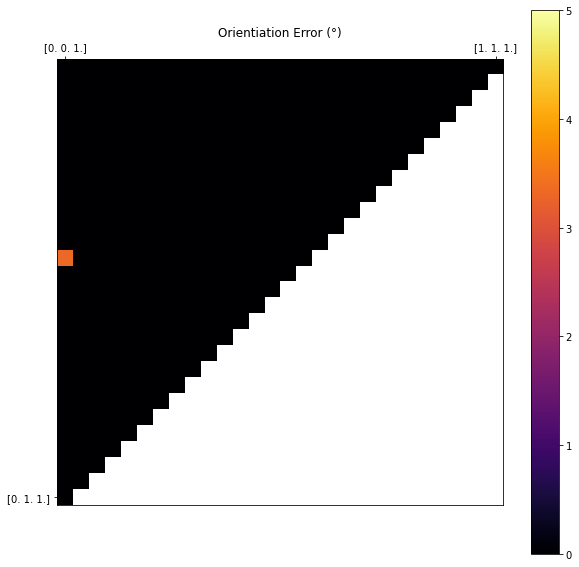

In [22]:
fig,ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap("inferno").copy()
cm.set_bad('w')
im = ax.imshow(np.rad2deg(error_img),cmap=cm,vmin=0,vmax=5)

label_0 = crystal.orientation_zone_axis_range[0,:]
label_0 = np.round(label_0 * 1e3) * 1e-3
label_0 /= np.min(np.abs(label_0[np.abs(label_0)>0]))

label_1 = crystal.orientation_zone_axis_range[1,:]
label_1 = np.round(label_1 * 1e3) * 1e-3
label_1 /= np.min(np.abs(label_1[np.abs(label_1)>0]))

label_2 = crystal.orientation_zone_axis_range[2,:]
label_2 = np.round(label_2 * 1e3) * 1e-3
label_2 /= np.min(np.abs(label_2[np.abs(label_2)>0]))

ax.set_yticks([crystal.orientation_zone_axis_steps])
ax.set_yticklabels([
    str(label_1)])

ax.set_xticks([0, crystal.orientation_zone_axis_steps])
ax.set_xticklabels([
    str(label_0),
    str(label_2)])
ax.xaxis.tick_top()

ax.set_title("Orientiation Error (°)")

fig.colorbar(im)
plt.show()

# Hexagonal and rational indexing

In [23]:
# Define titanium structure using manual input of the crystal structure
pos = np.array([
    [1/3, 2/3, 0.25],
    [2/3, 1/3, 0.75],
])

atom_num = 22

a = 2.95
c = 4.69
alpha = 90.0
gamma = 120.0

cell = [a,a,c,alpha,alpha,gamma]

crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

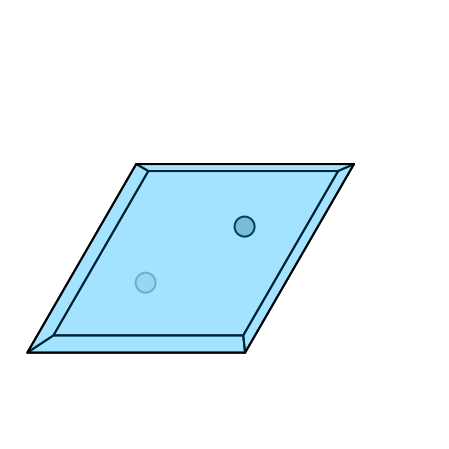

In [24]:
# Plot the structure
crystal.plot_structure(
#     zone_axis_lattice=[0,0,1],
    camera_dist=7,
)

### Hexagonal indexing

The py4DSTEM ACOM module now supports hexagonal indexing, which we will demonstrate here.

In [25]:
crystal.rational_ind( crystal.lattice_to_hexagonal([1,4,3]))

array([-2,  7, -5,  9])

In [26]:
print(crystal.rational_ind(crystal.lattice_to_hexagonal([1,0,0])), 
      crystal.rational_ind(crystal.lattice_to_hexagonal([0,1,0])),
      crystal.rational_ind(crystal.lattice_to_hexagonal([-1,-1,0])))

[ 2 -1 -1  0] [-1  2 -1  0] [-1 -1  2  0]


In [27]:
print(crystal.rational_ind(crystal.lattice_to_hexagonal([1,2,0])), 
      crystal.rational_ind(crystal.lattice_to_hexagonal([2,1,0])),
      crystal.rational_ind(crystal.lattice_to_hexagonal([-1,1,0])))

[ 0  1 -1  0] [ 1  0 -1  0] [-1  1  0  0]


In [28]:
crystal.rational_ind( crystal.hexagonal_to_lattice([2,0,-2,2]))

array([2, 1, 1])

In [29]:
print(crystal.rational_ind(crystal.hexagonal_to_lattice([2,-1,-1,0])), 
      crystal.rational_ind(crystal.hexagonal_to_lattice([-1,2,-1,0])),
      crystal.rational_ind(crystal.hexagonal_to_lattice([-1,-1,2,0])))

[1 0 0] [0 1 0] [-1 -1  0]


In [30]:
print(crystal.rational_ind(crystal.hexagonal_to_lattice([0,1,-1,0])), 
      crystal.rational_ind(crystal.hexagonal_to_lattice([1,0,-1,0])),
      crystal.rational_ind(crystal.hexagonal_to_lattice([-1,1,0,0])))

[1 2 0] [2 1 0] [-1  1  0]


In [31]:
# For arbitrary directions, the output crystallographic vectors may have large integer values:
print(crystal.rational_ind(
    crystal.lattice_to_hexagonal([-0.22,0.79,0.13]),10),
)

[-6  9 -3  2]


In [32]:
crystal.rational_ind([0.12391233,-0.2347335,0.774512],30)

array([ 520, -986, 3253])

In [33]:
3252/520

6.253846153846154

In [34]:
0.774512/0.12391233

6.250483708925496

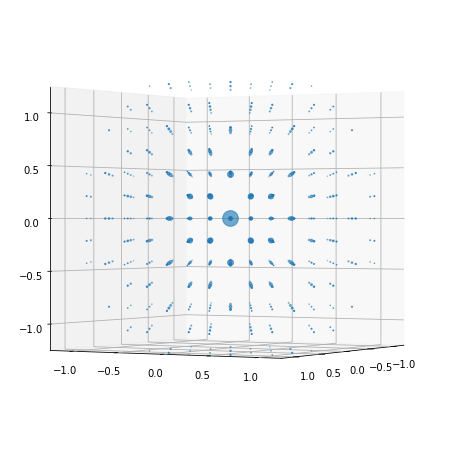

In [35]:
k_max = 1.5
crystal.calculate_structure_factors(k_max)

crystal.plot_structure_factors(
    # zone_axis_lattice=[1,0,-1,0],
    # zone_axis_lattice=[1,-1,0,0],
    # zone_axis_lattice=[0,1,-1,0],
    zone_axis_lattice=[1,1,-2,0],
    # zone_axis_lattice=[1,1,-2,0],
    # zone_axis_lattice=[1,1,-2,0],
    plot_limit=1.2,
)